In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [12]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')
data_df.head()

,training_set,y,dy,x
0,False,-3.751854,0.444200,AAAGCAAAA
1,True,-2.697741,0.369972,AAAGCAAAC
2,True,-2.242947,0.575121,AAAGCAAAG
3,False,-3.067251,0.357014,AAAGCAAAT
4,False,-2.987074,0.472637,AAAGCAACA


In [13]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 17,498
testing N: 4,431


In [4]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='dna',
                     gpmap_type='pairwise',                     
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)


In [5]:
# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'],
               shuffle=True)

N = 17,498 observations set as training data.
Data shuffled.
Time to set data: 0.366 sec.


In [6]:
# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    batch_size=200,
                    early_stopping=True,
                    early_stopping_patience=30)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    17498 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.323e+02  4.299e+03   1.0e+00  2.5e-01
     1  2.19200e-02  1.200e+02  1.397e+03   9.1e-01  1.5e-01  7.7e+01  1.0e+00
     2  2.59784e-02  1.186e+02  7.118e+02   9.0e-01  5.2e-02  1.1e+02  1.1e+00
     3  2.96533e-02  1.184e+02  2.279e+02   9.0e-01  7.5e-03  2.6e+02  2.4e+00
     4  3.10860e-02  1.183e+02  5.410e+01   8.9e-01  1.7e-03  2.7e+02  3.1e+00
     5  3.20917e-02  1.183e+02  1.251e+01   8.9e-01  3.7e-04  2.8e+02  3.4e+00
     6  3.22692e-02  1.183e+02  1.248e+00   8.9e-01  3.7e-05  2.9e+02  3.5e+00
     7  3.22536e-02  1.183e+02  2.542e-01   8.9e-01  7.2e-06  3.0e+02  3.5e+00
     8  3.22424e-02  1.183e+02  6.790e-02   8.9e-01  1.9e-06  3.0e+02  3.5

In [7]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [8]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [9]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

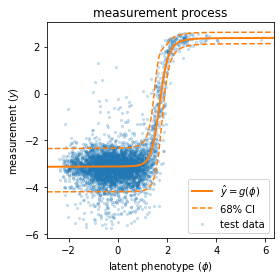

In [10]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

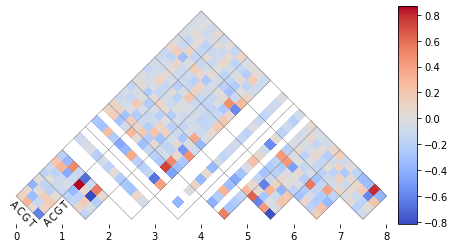

In [11]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);